In [1]:
import sys
import os
project_path = '../../..'
sys.path.append(os.path.abspath(project_path))

In [2]:
from matplotlib import pyplot as plt
import numpy as np

# Load Synthetic Data

In [3]:
num_states = 2
D = 1
emission_dist = 't'
save_path = '2013-2018_2states'
folder_path = f"{project_path}/data/synthetic/{emission_dist}-hmm/{save_path}"
s_filename = f"{folder_path}/S_data.npy"
x_filename = f"{folder_path}/X_data.npy"
S = np.load(s_filename)
X = np.load(x_filename)

In [4]:
from data_code.dataloader import create_dataloaders, create_datasets

window_size = 390
batch_size = 32

train_loader, val_loader, test_loader = create_dataloaders(
    X, S, window_size=window_size, train_ratio=0.6, val_ratio=0.2, batch_size=batch_size, standardize=True, feature_engineer=True
)

# Search the Best Hyper-parameter for Mixture-VAE

In [5]:
class ModelParams:
    name = 'mixture_vae'
    
    # backbone parameters
    tau = 0.1
    hard = False
    transition = 'jump'
    lamda_m = 1.0
    lamda_i = 1.0
    lamda_t = 1.0
    seq_len = window_size
    feature = D * 15
    n_cluster = num_states
    hidden_dim = 16
    loss_clamp = batch_size * window_size * 10
    loss_mode = 'sum'
    
    # s_x
    s_x_type = 'lstm'
    s_clamp = 5
    s_x_dropout = 0.1
    s_x_lstm_hidden = 64
    s_x_lstm_layers = 1
    
    # z_s (p)
    
    # z_sx (q)
    z_sx_type = 'mlp'
    z_sx_dropout = 0.1
    z_sx_hiddens = [128, 128]
    
    ######################################
    reconstruction_on_s = True # if True use x_sz else x_z
    
    # x_sz
    x_sz_type = 'mlp'
    reconstruction_on_z = 'p'
    x_sz_dropout = 0.1
    x_sz_hiddens = [128, 128]
    
    # x_z
    x_z_type = 'mlp'
    reconstruction_on_z = 'p'
    x_z_dropout = 0.1
    x_z_hiddens = [128, 128]

model_params = ModelParams

In [6]:
import optuna
import numpy as np
import json
from model.vae_module import VAEModule
from utils.metrics import balanced_accuracy
import os

# Construct the grid for lamda
grid_values = [1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 9.0, 12.0, 15.0, 20.0, 30.0, 40.0, 60.0, 80.0, 100.0]

def objective(trial):
    # Select a lamda value from the predefined grid
    lamda = trial.suggest_categorical("lamda", grid_values)
    
    # Assign the lamda value to the model parameters
    model_params.lamda_m = lamda
    model_params.lamda_i = lamda
    model_params.lamda_t = lamda
    
    vae_module = VAEModule(model_params)
    vae_module.fit(train_loader, lr=1e-3, epochs=300)
    
    # Evaluate model performance on the validation set
    true_s_val, pred_s_val = vae_module.inference(val_loader)
    val_bal_acc = balanced_accuracy(true_s_val.ravel(), pred_s_val.ravel(), n_classes=num_states)
    
    return val_bal_acc

# Define the search space
search_space = {"lamda": grid_values}
sampler = optuna.samplers.GridSampler(search_space)

# Create an Optuna Study with the objective of maximizing Balanced Accuracy
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective)

# Output the best hyperparameters
print("Best trial:")
best_trial = study.best_trial
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Save the best hyperparameters to a file
best_params = best_trial.params

os.makedirs(f"{project_path}/hyper_parameter/best_vae", exist_ok=True)
param_file_name = f"{project_path}/hyper_parameter/best_vae/{save_path}.json"
with open(param_file_name, "w") as f:
    json.dump(best_params, f, indent=4)

print("Best hyperparameters saved to 'best_hyperparameters.json'.")


[I 2025-03-24 13:59:03,099] A new study created in memory with name: no-name-47ed6ff2-f341-41b2-97c0-249cd8553648


Epoch [20/300], VAE Loss: 6962.7019
Epoch [40/300], VAE Loss: 6843.3974
Epoch [60/300], VAE Loss: 6815.6605
Epoch [80/300], VAE Loss: 6802.7383
Epoch [100/300], VAE Loss: 6790.5633
Epoch [120/300], VAE Loss: 6785.2253
Epoch [140/300], VAE Loss: 6782.5319
Epoch [160/300], VAE Loss: 6779.1881
Epoch [180/300], VAE Loss: 6772.4429
Epoch [200/300], VAE Loss: 6766.0817
Epoch [220/300], VAE Loss: 6768.2593
Epoch [240/300], VAE Loss: 6767.4576
Epoch [260/300], VAE Loss: 6759.4848
Epoch [280/300], VAE Loss: 6769.3502


[I 2025-03-24 13:59:34,985] Trial 0 finished with value: 0.5341934007888324 and parameters: {'lamda': 2.0}. Best is trial 0 with value: 0.5341934007888324.


Epoch [300/300], VAE Loss: 6759.6232
Epoch [20/300], VAE Loss: 14614.8836
Epoch [40/300], VAE Loss: 13639.6634
Epoch [60/300], VAE Loss: 13531.6855
Epoch [80/300], VAE Loss: 13484.1366
Epoch [100/300], VAE Loss: 13447.2257
Epoch [120/300], VAE Loss: 13422.5278
Epoch [140/300], VAE Loss: 13406.3621
Epoch [160/300], VAE Loss: 13394.8850
Epoch [180/300], VAE Loss: 13368.8456
Epoch [200/300], VAE Loss: 13360.7933
Epoch [220/300], VAE Loss: 13343.6364
Epoch [240/300], VAE Loss: 13331.5470
Epoch [260/300], VAE Loss: 13328.1093
Epoch [280/300], VAE Loss: 13327.8090


[I 2025-03-24 14:00:20,002] Trial 1 finished with value: 0.549501581285143 and parameters: {'lamda': 9.0}. Best is trial 1 with value: 0.549501581285143.


Epoch [300/300], VAE Loss: 13315.5523
Epoch [20/300], VAE Loss: 20352.6354
Epoch [40/300], VAE Loss: 19432.1156
Epoch [60/300], VAE Loss: 19097.8346
Epoch [80/300], VAE Loss: 18998.6189
Epoch [100/300], VAE Loss: 18942.0819
Epoch [120/300], VAE Loss: 18899.7929
Epoch [140/300], VAE Loss: 18865.9955
Epoch [160/300], VAE Loss: 18852.5208
Epoch [180/300], VAE Loss: 18830.1029
Epoch [200/300], VAE Loss: 18812.6066
Epoch [220/300], VAE Loss: 18805.8196
Epoch [240/300], VAE Loss: 18804.4142
Epoch [260/300], VAE Loss: 18786.0746
Epoch [280/300], VAE Loss: 18793.5388


[I 2025-03-24 14:01:06,178] Trial 2 finished with value: 0.5550266945376143 and parameters: {'lamda': 15.0}. Best is trial 2 with value: 0.5550266945376143.


Epoch [300/300], VAE Loss: 18784.7635
Epoch [20/300], VAE Loss: 24347.2933
Epoch [40/300], VAE Loss: 23680.8362
Epoch [60/300], VAE Loss: 23543.5650
Epoch [80/300], VAE Loss: 23472.3676
Epoch [100/300], VAE Loss: 23424.4252
Epoch [120/300], VAE Loss: 23379.2267
Epoch [140/300], VAE Loss: 23351.8832
Epoch [160/300], VAE Loss: 23339.6605
Epoch [180/300], VAE Loss: 23316.6761
Epoch [200/300], VAE Loss: 23313.3435
Epoch [220/300], VAE Loss: 23309.4338
Epoch [240/300], VAE Loss: 23295.4461
Epoch [260/300], VAE Loss: 23287.6311
Epoch [280/300], VAE Loss: 23286.5065


[I 2025-03-24 14:01:52,584] Trial 3 finished with value: 0.6336553761255599 and parameters: {'lamda': 20.0}. Best is trial 3 with value: 0.6336553761255599.


Epoch [300/300], VAE Loss: 23296.3317
Epoch [20/300], VAE Loss: 102098.6291
Epoch [40/300], VAE Loss: 96567.8072
Epoch [60/300], VAE Loss: 95812.1176
Epoch [80/300], VAE Loss: 95408.3023
Epoch [100/300], VAE Loss: 95152.3660
Epoch [120/300], VAE Loss: 94944.1585
Epoch [140/300], VAE Loss: 94792.5441
Epoch [160/300], VAE Loss: 94681.6275
Epoch [180/300], VAE Loss: 94607.4771
Epoch [200/300], VAE Loss: 94555.4935
Epoch [220/300], VAE Loss: 94510.2908
Epoch [240/300], VAE Loss: 94472.5670
Epoch [260/300], VAE Loss: 94443.0343
Epoch [280/300], VAE Loss: 94409.8595


[I 2025-03-24 14:02:38,800] Trial 4 finished with value: 0.5 and parameters: {'lamda': 100.0}. Best is trial 3 with value: 0.6336553761255599.


Epoch [300/300], VAE Loss: 94387.7565
Epoch [20/300], VAE Loss: 10510.7913
Epoch [40/300], VAE Loss: 9809.3821
Epoch [60/300], VAE Loss: 9751.9640
Epoch [80/300], VAE Loss: 9703.6652
Epoch [100/300], VAE Loss: 9666.8388
Epoch [120/300], VAE Loss: 9658.4186
Epoch [140/300], VAE Loss: 9636.1900
Epoch [160/300], VAE Loss: 9633.8752
Epoch [180/300], VAE Loss: 9630.3276
Epoch [200/300], VAE Loss: 9624.4144
Epoch [220/300], VAE Loss: 9617.8709
Epoch [240/300], VAE Loss: 9615.0423
Epoch [260/300], VAE Loss: 9612.8558
Epoch [280/300], VAE Loss: 9606.1591


[I 2025-03-24 14:03:25,056] Trial 5 finished with value: 0.5395555968661361 and parameters: {'lamda': 5.0}. Best is trial 3 with value: 0.6336553761255599.


Epoch [300/300], VAE Loss: 9603.4337
Epoch [20/300], VAE Loss: 7919.2541
Epoch [40/300], VAE Loss: 7810.0727
Epoch [60/300], VAE Loss: 7782.5891
Epoch [80/300], VAE Loss: 7768.6128
Epoch [100/300], VAE Loss: 7760.4915
Epoch [120/300], VAE Loss: 7750.0855
Epoch [140/300], VAE Loss: 7742.7337
Epoch [160/300], VAE Loss: 7733.9139
Epoch [180/300], VAE Loss: 7732.1848
Epoch [200/300], VAE Loss: 7727.4701
Epoch [220/300], VAE Loss: 7725.9388
Epoch [240/300], VAE Loss: 7721.0642
Epoch [260/300], VAE Loss: 7721.5258
Epoch [280/300], VAE Loss: 7715.4631


[I 2025-03-24 14:04:11,657] Trial 6 finished with value: 0.5370761746276976 and parameters: {'lamda': 3.0}. Best is trial 3 with value: 0.6336553761255599.


Epoch [300/300], VAE Loss: 7713.9419
Epoch [20/300], VAE Loss: 81991.8431
Epoch [40/300], VAE Loss: 78635.2631
Epoch [60/300], VAE Loss: 77991.6528
Epoch [80/300], VAE Loss: 77576.2328
Epoch [100/300], VAE Loss: 77316.2492
Epoch [120/300], VAE Loss: 77118.2778
Epoch [140/300], VAE Loss: 76984.1119
Epoch [160/300], VAE Loss: 76896.3742
Epoch [180/300], VAE Loss: 76831.5940
Epoch [200/300], VAE Loss: 76784.1781
Epoch [220/300], VAE Loss: 76757.4052
Epoch [240/300], VAE Loss: 76722.1299
Epoch [260/300], VAE Loss: 76697.2271
Epoch [280/300], VAE Loss: 76662.7941


[I 2025-03-24 14:04:58,006] Trial 7 finished with value: 0.6410951063994226 and parameters: {'lamda': 80.0}. Best is trial 7 with value: 0.6410951063994226.


Epoch [300/300], VAE Loss: 76642.0376
Epoch [20/300], VAE Loss: 34693.4939
Epoch [40/300], VAE Loss: 33074.3158
Epoch [60/300], VAE Loss: 32739.2467
Epoch [80/300], VAE Loss: 32577.3292
Epoch [100/300], VAE Loss: 32473.8150
Epoch [120/300], VAE Loss: 32402.7349
Epoch [140/300], VAE Loss: 32360.5768
Epoch [160/300], VAE Loss: 32342.5351
Epoch [180/300], VAE Loss: 32308.6895
Epoch [200/300], VAE Loss: 32293.9069
Epoch [220/300], VAE Loss: 32280.1409
Epoch [240/300], VAE Loss: 32271.6107
Epoch [260/300], VAE Loss: 32255.8043
Epoch [280/300], VAE Loss: 32261.6781


[I 2025-03-24 14:05:44,135] Trial 8 finished with value: 0.5844722086921512 and parameters: {'lamda': 30.0}. Best is trial 7 with value: 0.6410951063994226.


Epoch [300/300], VAE Loss: 32248.7998
Epoch [20/300], VAE Loss: 16860.2300
Epoch [40/300], VAE Loss: 16348.6799
Epoch [60/300], VAE Loss: 16248.5076
Epoch [80/300], VAE Loss: 16200.9737
Epoch [100/300], VAE Loss: 16161.3511
Epoch [120/300], VAE Loss: 16130.8554
Epoch [140/300], VAE Loss: 16136.5453
Epoch [160/300], VAE Loss: 16103.8985
Epoch [180/300], VAE Loss: 16092.0715
Epoch [200/300], VAE Loss: 16088.0411
Epoch [220/300], VAE Loss: 16077.8235
Epoch [240/300], VAE Loss: 16073.2204
Epoch [260/300], VAE Loss: 16059.8503
Epoch [280/300], VAE Loss: 16065.7335


[I 2025-03-24 14:06:30,421] Trial 9 finished with value: 0.5528461720369422 and parameters: {'lamda': 12.0}. Best is trial 7 with value: 0.6410951063994226.


Epoch [300/300], VAE Loss: 16053.6914
Epoch [20/300], VAE Loss: 43341.5596
Epoch [40/300], VAE Loss: 42206.3333
Epoch [60/300], VAE Loss: 41845.9473
Epoch [80/300], VAE Loss: 41646.5404
Epoch [100/300], VAE Loss: 41531.5907
Epoch [120/300], VAE Loss: 41435.8047
Epoch [140/300], VAE Loss: 41358.5490
Epoch [160/300], VAE Loss: 41300.1544
Epoch [180/300], VAE Loss: 41263.7198
Epoch [200/300], VAE Loss: 41229.2002
Epoch [220/300], VAE Loss: 41202.7410
Epoch [240/300], VAE Loss: 41182.7165
Epoch [260/300], VAE Loss: 41173.3337
Epoch [280/300], VAE Loss: 41154.7749


[I 2025-03-24 14:07:16,464] Trial 10 finished with value: 0.6359296690791418 and parameters: {'lamda': 40.0}. Best is trial 7 with value: 0.6410951063994226.


Epoch [300/300], VAE Loss: 41147.8145
Epoch [20/300], VAE Loss: 9014.5787
Epoch [40/300], VAE Loss: 8804.7309
Epoch [60/300], VAE Loss: 8756.8066
Epoch [80/300], VAE Loss: 8733.2254
Epoch [100/300], VAE Loss: 8720.3415
Epoch [120/300], VAE Loss: 8714.1809
Epoch [140/300], VAE Loss: 8696.8659
Epoch [160/300], VAE Loss: 8692.2711
Epoch [180/300], VAE Loss: 8686.3342
Epoch [200/300], VAE Loss: 8685.8622
Epoch [220/300], VAE Loss: 8679.1565
Epoch [240/300], VAE Loss: 8678.2650
Epoch [260/300], VAE Loss: 8674.7211
Epoch [280/300], VAE Loss: 8664.9984


[I 2025-03-24 14:08:02,359] Trial 11 finished with value: 0.5364178557223984 and parameters: {'lamda': 4.0}. Best is trial 7 with value: 0.6410951063994226.


Epoch [300/300], VAE Loss: 8671.6349
Epoch [20/300], VAE Loss: 6201.9758
Epoch [40/300], VAE Loss: 5956.8921
Epoch [60/300], VAE Loss: 5845.9875
Epoch [80/300], VAE Loss: 5820.3882
Epoch [100/300], VAE Loss: 5815.6690
Epoch [120/300], VAE Loss: 5810.5218
Epoch [140/300], VAE Loss: 5806.2851
Epoch [160/300], VAE Loss: 5801.9854
Epoch [180/300], VAE Loss: 5799.4626
Epoch [200/300], VAE Loss: 5798.4582
Epoch [220/300], VAE Loss: 5796.8412
Epoch [240/300], VAE Loss: 5795.1332
Epoch [260/300], VAE Loss: 5794.7911
Epoch [280/300], VAE Loss: 5792.9960


[I 2025-03-24 14:08:48,845] Trial 12 finished with value: 0.5332717440508271 and parameters: {'lamda': 1.0}. Best is trial 7 with value: 0.6410951063994226.


Epoch [300/300], VAE Loss: 5789.3382
Epoch [20/300], VAE Loss: 12272.6236
Epoch [40/300], VAE Loss: 11737.7878
Epoch [60/300], VAE Loss: 11646.8672
Epoch [80/300], VAE Loss: 11608.7506
Epoch [100/300], VAE Loss: 11569.2894
Epoch [120/300], VAE Loss: 11550.2310
Epoch [140/300], VAE Loss: 11534.1597
Epoch [160/300], VAE Loss: 11522.3652
Epoch [180/300], VAE Loss: 11518.2300
Epoch [200/300], VAE Loss: 11500.3305
Epoch [220/300], VAE Loss: 11502.0529
Epoch [240/300], VAE Loss: 11491.6708
Epoch [260/300], VAE Loss: 11500.5008
Epoch [280/300], VAE Loss: 11485.3192


[I 2025-03-24 14:09:35,336] Trial 13 finished with value: 0.5420495519841875 and parameters: {'lamda': 7.0}. Best is trial 7 with value: 0.6410951063994226.


Epoch [300/300], VAE Loss: 11479.5974
Epoch [20/300], VAE Loss: 65450.3864
Epoch [40/300], VAE Loss: 60756.2982
Epoch [60/300], VAE Loss: 60176.0556
Epoch [80/300], VAE Loss: 59857.4739
Epoch [100/300], VAE Loss: 59627.6838
Epoch [120/300], VAE Loss: 59467.6209
Epoch [140/300], VAE Loss: 59351.0294
Epoch [160/300], VAE Loss: 59261.4812
Epoch [180/300], VAE Loss: 59194.7255
Epoch [200/300], VAE Loss: 59150.9167
Epoch [220/300], VAE Loss: 59114.2337
Epoch [240/300], VAE Loss: 59078.5049
Epoch [260/300], VAE Loss: 59028.7712
Epoch [280/300], VAE Loss: 59001.9722


[I 2025-03-24 14:10:21,739] Trial 14 finished with value: 0.6259491754901702 and parameters: {'lamda': 60.0}. Best is trial 7 with value: 0.6410951063994226.


Epoch [300/300], VAE Loss: 58965.9346
Best trial:
  lamda: 80.0
Best hyperparameters saved to 'best_hyperparameters.json'.


In [7]:
# Load the best hyper-parameter
with open(param_file_name, "r") as f:
    loaded_params = json.load(f)

print("Loaded hyperparameters:")
print(loaded_params)

model_params.lamda_m = loaded_params['lamda']
model_params.lamda_i = loaded_params['lamda']
model_params.lamda_t = loaded_params['lamda']

vae_module = VAEModule(model_params)
vae_module.fit(train_loader, lr=1e-3, epochs=300)

Loaded hyperparameters:
{'lamda': 80.0}
Epoch [20/300], VAE Loss: 82460.3848
Epoch [40/300], VAE Loss: 78231.5784
Epoch [60/300], VAE Loss: 77738.4992
Epoch [80/300], VAE Loss: 77441.1275
Epoch [100/300], VAE Loss: 77233.7565
Epoch [120/300], VAE Loss: 77066.0743
Epoch [140/300], VAE Loss: 76922.3366
Epoch [160/300], VAE Loss: 76826.2222
Epoch [180/300], VAE Loss: 76755.5261
Epoch [200/300], VAE Loss: 76716.6765
Epoch [220/300], VAE Loss: 76684.7647
Epoch [240/300], VAE Loss: 76651.3725
Epoch [260/300], VAE Loss: 76631.4575
Epoch [280/300], VAE Loss: 76607.8578
Epoch [300/300], VAE Loss: 76587.7190


In [8]:
true_s_train_vae, pred_s_train_vae = vae_module.inference(train_loader)
true_s_test_vae, pred_s_test_vae = vae_module.inference(test_loader)

vae_bal_acc_train = balanced_accuracy(true_s_train_vae.ravel(), pred_s_train_vae.ravel(), n_classes = num_states)
vae_bal_acc_test = balanced_accuracy(true_s_test_vae.ravel(), pred_s_test_vae.ravel(), n_classes = num_states)
print(f"[VAE] Balanced Accuracy [train]: {vae_bal_acc_train:.4f}")
print(f"[VAE] Balanced Accuracy [test]: {vae_bal_acc_test:.4f}")

[VAE] Balanced Accuracy [train]: 0.6353
[VAE] Balanced Accuracy [test]: 0.6254


# Visualization

In [9]:
from utils.visualize import plot_clusters
num = 8
all_x_input, all_z_embed = vae_module.get_embedding(test_loader)
original_embed = all_x_input[:num].reshape(-1, all_x_input.shape[-1])
latent_embed = all_z_embed[:num].reshape(-1, all_z_embed.shape[-1])
pred_label = pred_s_test_vae[:num].ravel()
true_label = true_s_test_vae[:num].ravel()

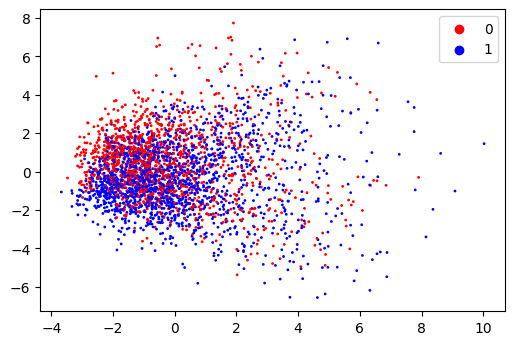

In [10]:
plot_clusters(
    data=original_embed,        
    cluster_labels=true_label,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=None,
    dpi=100,
    marker_size=1
)

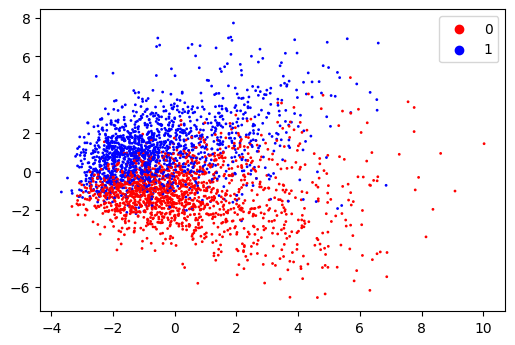

In [11]:
plot_clusters(
    data=original_embed,        
    cluster_labels=pred_label,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=None,
    dpi=100,
    marker_size=1
)

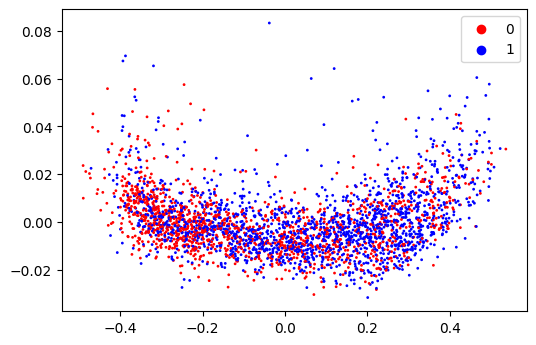

In [12]:
plot_clusters(
    data=latent_embed,        
    cluster_labels=true_label,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=None,
    dpi=100,
    marker_size=1
)

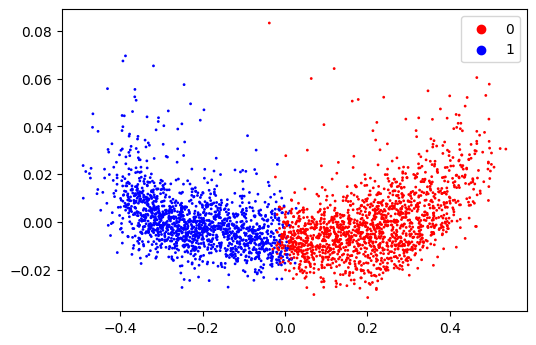

In [13]:
plot_clusters(
    data=latent_embed,        
    cluster_labels=pred_label,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=None,
    dpi=100,
    marker_size=1
)